In [1]:
import numpy as np
import os
import h5py
import pandas as pd
from time import time

from joblib import Parallel, delayed

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.stats import spearmanr, wilcoxon

from LBP_components import Conv_MRELBP
from Components import local_normalize

import matplotlib.pyplot as plt

np.random.seed(42)

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Paths and files
path_surf = '../cartvoi_surf_new/'
files_surf = os.listdir(path_surf)
files_surf.sort()
path_deep = '../cartvoi_deep_new/'
files_deep = os.listdir(path_deep)
files_deep.sort()
path_calc = '../cartvoi_calc_new/'
files_calc = os.listdir(path_calc)
files_calc.sort()

save_path = './results.csv'

#Image loading
im_surf = []
im_deep = []
im_calc = []

for fsurf,fdeep,fcalc in zip(files_surf,files_deep,files_calc):
    h5 = h5py.File(os.path.join(path_surf,fsurf),'r')
    ims = h5['sum'][:]
    h5.close()
    im_surf.append(ims)
    h5 = h5py.File(os.path.join(path_deep,fdeep),'r')
    imd = h5['sum'][24:-24,24:-24]
    h5.close()
    im_deep.append(imd)
    h5 = h5py.File(os.path.join(path_calc,fcalc),'r')
    imc = h5['sum'][24:-24,24:-24]
    h5.close()
    im_calc.append(imc)
    
#Grades
df = pd.read_excel('../ERCGrades.xlsx')
sgrades = np.array(df['surf_sub'])
dgrades = np.array(df['deep_mat'])
cgrades = np.array(df['calc_mat'])

In [3]:
#Feature extration

#args_surf = {'ks1': 9, 'sigma1': 3, 'ks2': 21, 'sigma2': 15, 'R': 18, 'r': 5, 'wc': 7, 'wR': 9, 'wr': 3}
args_surf = {'ks1': 17, 'sigma1': 7, 'ks2': 17, 'sigma2': 1, 'R': 23, 'r': 2, 'wc': 5, 'wR': 15, 'wr': 3} 
#args_deep = {'ks1': 25, 'sigma1': 12, 'ks2': 9, 'sigma2': 7, 'R': 27, 'r': 7, 'wc': 13, 'wR': 3, 'wr': 3}
args_deep = {'ks1': 15, 'sigma1': 3, 'ks2': 23, 'sigma2': 13, 'R': 16, 'r': 12, 'wc': 13, 'wR': 15, 'wr': 9}
#args_calc = {'ks1': 11, 'sigma1': 11, 'ks2': 23, 'sigma2': 3, 'R': 3, 'r': 2, 'wc': 11, 'wR': 5, 'wr': 5}
args_calc = {'ks1': 13, 'sigma1': 1, 'ks2': 23, 'sigma2': 7, 'R': 19, 'r': 18, 'wc': 3, 'wR': 3, 'wr': 11}

features_surf = Parallel(n_jobs=4)(delayed(Conv_MRELBP)
                                    (local_normalize(img,args_surf['ks1'],args_surf['sigma1'],args_surf['ks2'],args_surf['sigma2']),
                                     8,args_surf['R'],args_surf['r'],args_surf['wR'],args_surf['wr'],args_surf['wc']) for img in im_surf)
features_deep = Parallel(n_jobs=4)(delayed(Conv_MRELBP)
                                    (local_normalize(img,args_deep['ks1'],args_deep['sigma1'],args_deep['ks2'],args_deep['sigma2']),
                                     8,args_deep['R'],args_deep['r'],args_deep['wR'],args_deep['wr'],args_deep['wc']) for img in im_deep)
features_calc = Parallel(n_jobs=4)(delayed(Conv_MRELBP)
                                    (local_normalize(img,args_calc['ks1'],args_calc['sigma1'],args_calc['ks2'],args_calc['sigma2']),
                                     8,args_calc['R'],args_calc['r'],args_calc['wR'],args_calc['wr'],args_calc['wc']) for img in im_calc)

features_surf = np.array(features_surf).squeeze()
features_deep = np.array(features_deep).squeeze()
features_calc = np.array(features_calc).squeeze()

save = r'Z:\3DHistoData\Grading'
writer = pd.ExcelWriter(save + r'\LBP_features_surfconv.xlsx')
df1 = pd.DataFrame(features_surf)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()
writer = pd.ExcelWriter(save + r'\LBP_features_deepconv.xlsx')
df1 = pd.DataFrame(features_deep)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()
writer = pd.ExcelWriter(save + r'\LBP_features_calcconv.xlsx')
df1 = pd.DataFrame(features_calc)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()

In [4]:
#PCA
pcasurf = PCA(20,whiten=True,random_state=42)
surfpc = pcasurf.fit(features_surf).transform(features_surf)

pcadeep = PCA(20,whiten=True,random_state=42)
deeppc = pcadeep.fit(features_deep).transform(features_deep)

pcacalc = PCA(20,whiten=True,random_state=42)
calcpc = pcacalc.fit(features_calc).transform(features_calc)

In [5]:
#Regression

#Get splits
loo_surf = LeaveOneOut()
loo_surf.get_n_splits(surfpc)
loo_deep = LeaveOneOut()
loo_deep.get_n_splits(deeppc)
loo_calc = LeaveOneOut()
loo_calc.get_n_splits(calcpc)

#Evaluate surface
surfp = []
surfp_log = []
for train_idx, test_idx in loo_surf.split(surfpc):
    #Train split
    f = surfpc[train_idx]-surfpc.mean(0)
    g = sgrades[train_idx]
    
    #Linear regression
    Rmodel = Ridge(alpha=1,normalize=True,random_state=42)
    Rmodel.fit(f,g.reshape(-1,1))
    
    #Logistic regression
    Lmodel = LogisticRegression(solver='newton-cg',max_iter=1000)
    Lmodel.fit(f,g.ravel()>1)
    
    #Evaluate on test sample
    p = Rmodel.predict((surfpc[test_idx]-surfpc.mean(0)).reshape(1,-1))
    p_log = Lmodel.predict_proba((surfpc[test_idx]-surfpc.mean(0)).reshape(1,-1))
    surfp.append(p)
    surfp_log.append(p_log[0,1])

#Evaluate deep cartilage
deepp = []
deepp_log = []
for train_idx, test_idx in loo_deep.split(deeppc):
    #Train split
    f = deeppc[train_idx]-deeppc.mean(0)
    g = dgrades[train_idx]
    
    #Linear regression
    Rmodel = Ridge(alpha=1,normalize=True,random_state=42)
    Rmodel.fit(f,g.reshape(-1,1))
    
    #Logistic regression
    Lmodel = LogisticRegression(solver='newton-cg',max_iter=1000)
    Lmodel.fit(f,g.ravel()>1)
    
    #Evaluate on test sample
    p = Rmodel.predict((deeppc[test_idx]-deeppc.mean(0)).reshape(1,-1))
    p_log = Lmodel.predict_proba((deeppc[test_idx]-deeppc.mean(0)).reshape(1,-1))
    deepp.append(p)
    deepp_log.append(p_log[0,1])
    
#Evaluate calcified cartilage
calcp = []
calcp_log = []
for train_idx, test_idx in loo_surf.split(calcpc):
    #Train split
    f = calcpc[train_idx]-calcpc.mean(0)
    g = cgrades[train_idx]
    
    #Linear regression
    Rmodel = Ridge(alpha=1,normalize=True,random_state=42)
    Rmodel.fit(f,g.reshape(-1,1))
    
    #Logistic regression
    Lmodel = LogisticRegression(solver='newton-cg',max_iter=1000)
    Lmodel.fit(f,g.ravel()>1)
    
    #Evaluate on test sample
    p = Rmodel.predict((calcpc[test_idx]-calcpc.mean(0)).reshape(1,-1))
    p_log = Lmodel.predict_proba((calcpc[test_idx]-calcpc.mean(0)).reshape(1,-1))
    calcp.append(p)
    calcp_log.append(p_log[0,1])


In [6]:
#Predictions to array
surfp = np.array(surfp).squeeze()
surfp_log = np.array(surfp_log).squeeze()
deepp = np.array(deepp).squeeze()
deepp_log = np.array(deepp_log).squeeze()
calcp = np.array(calcp).squeeze()
calcp_log = np.array(calcp_log).squeeze()

In [7]:
#MSEs
def MSE(preds,targets):
    N = len(preds)
    errors = preds.flatten()-targets.flatten()
    return (errors**2).sum()/N

print(MSE(surfp,sgrades))
print(MSE(deepp,dgrades))
print(MSE(calcp,cgrades))

0.5256140029855523
0.4730186510682121
0.44507831601470194


[0.9504643962848297, 0.730909090909091, 0.9307692307692308]


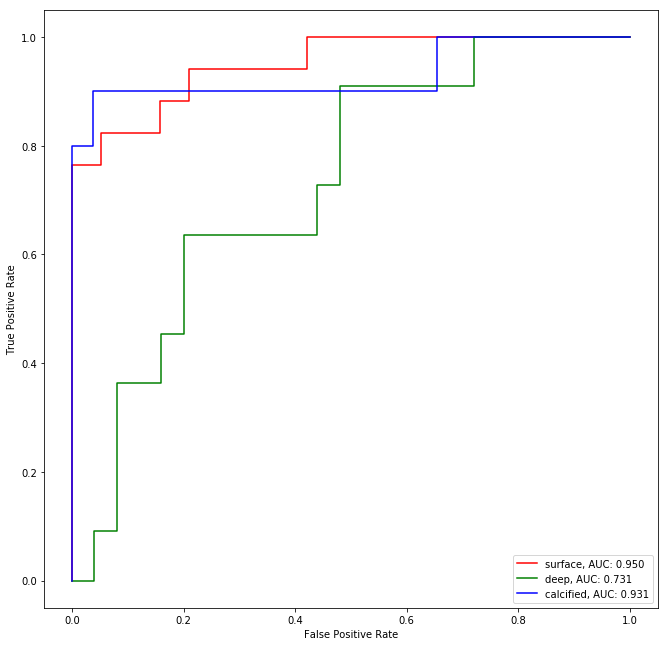

In [14]:
#ROC curves
sfpr,stpr,_ = roc_curve(sgrades>1,surfp_log,pos_label=1)
dfpr,dtpr,_ = roc_curve(dgrades>1,deepp_log,pos_label=1)
cfpr,ctpr,_ = roc_curve(cgrades>1,calcp_log,pos_label=1)

#AUC scores
sscore = roc_auc_score(sgrades>1,surfp_log)
dscore = roc_auc_score(dgrades>1,deepp_log)
cscore = roc_auc_score(cgrades>1,calcp_log)
print([sscore,dscore,cscore])

plt.figure(figsize=(11,11))
plt.plot(sfpr,stpr,color='r')
plt.plot(dfpr,dtpr,color='g')
plt.plot(cfpr,ctpr,color='b')
plt.legend(['surface, AUC: {:0.3f}'.format(sscore),
            'deep, AUC: {:0.3f}'.format(dscore),
            'calcified, AUC: {:0.3f}'.format(cscore)],loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
savepath = r'Z:\3DHistoData\Grading\ROC.png'
plt.savefig(savepath, bbox_inches='tight')
plt.show()



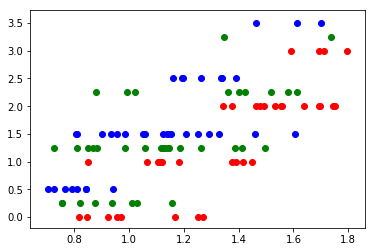

In [9]:
plt.scatter(surfp,sgrades,color='r')
plt.scatter(deepp,dgrades+0.25,color='g')
plt.scatter(calcp,cgrades+0.5,color='b')
plt.show()

In [10]:
#Statistics

#Spearman rho
srho = spearmanr(sgrades,surfp)
drho = spearmanr(dgrades,deepp)
crho = spearmanr(cgrades,calcp)

print([srho[0],drho[0],crho[0]])

#Wilcoxon p
swilc = wilcoxon(sgrades,surfp)
dwilc = wilcoxon(dgrades,deepp)
cwilc = wilcoxon(cgrades,calcp)

print([swilc[1],dwilc[1],cwilc[1]])

[0.8509734373257272, 0.5692168714315511, 0.7908785553999731]
[0.7414588442222838, 0.9373882722307465, 0.729618806544102]


In [11]:
# Save features

save = r'Z:\3DHistoData\Grading'
writer = pd.ExcelWriter(save + r'\LBP_features_surfconv.xlsx')
df1 = pd.DataFrame(features_surf)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()
writer = pd.ExcelWriter(save + r'\LBP_features_deepconv.xlsx')
df1 = pd.DataFrame(features_deep)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()
writer = pd.ExcelWriter(save + r'\LBP_features_calcconv.xlsx')
df1 = pd.DataFrame(features_calc)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()

In [12]:
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
